In [1]:
import pandas as pd

In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [5]:
%pip install pyarrow

     |████████████████████████████████| 29.4 MB 4.2 MB/s eta 0:00:01


In [6]:
df = pd.read_parquet('../../dataset/green_tripdata_2022-01.parquet')

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [7]:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
std,0.357556,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000


In [8]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [9]:
# create the target value
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333


<Figure size 1500x900 with 0 Axes>

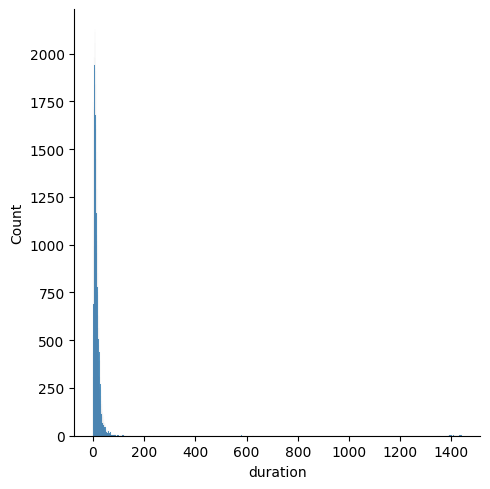

In [15]:
# draw the duration distribution
plt.figure(figsize=(15,9))
sns.displot(df['duration'])

The duration distribution seems to have a very long tail, let's check it's mean, std deviation

In [17]:
df.duration.describe()

count    62495.000000
mean        19.019387
std         78.215732
min          0.000000
25%          7.000000
50%         11.583333
75%         18.200000
max       1439.466667
Name: duration, dtype: float64

In [19]:
# we can also check how much 95% and 99.7% percentile hold
df.duration.describe(percentiles=[0.95, 0.99, 0.997])

count    62495.000000
mean        19.019387
std         78.215732
min          0.000000
50%         11.583333
95%         35.438333
99%         68.453000
99.7%      939.596167
max       1439.466667
Name: duration, dtype: float64

In [20]:
# we will filter our duration based on the above statistics
df = df[(df['duration'] >= 1) & (df['duration'] <= 69)]

In [21]:
df.shape

(59814, 21)

In [22]:
print(df.columns)

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')


/home/ubuntu/anaconda3/envs/ml-ops/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_type', ylabel='count'>

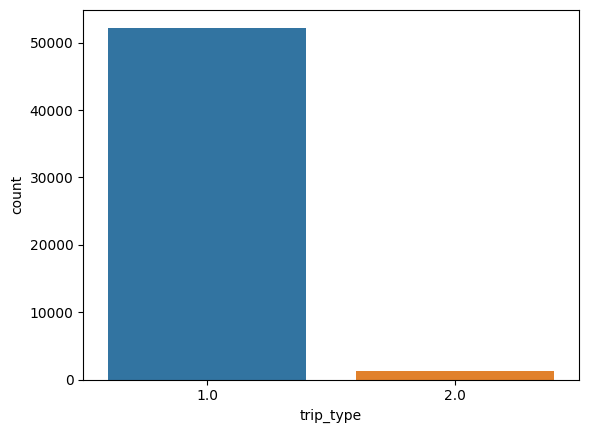

In [23]:
# check trip type
sns.countplot(df['trip_type'])

Trip type will have a very little impact on the dataset due as almost all values are 1.0, so we will not take this feature

Let's see whether there is any correlation between number of passenger and trip duration

In [28]:
df[['passenger_count', 'duration']].corr()

,passenger_count,duration
passenger_count,1.000000,0.000651
duration,0.000651,1.000000


There is little to no correlation between passenger count and duration. as passenger count hardly depends on trip duration.

<AxesSubplot:>

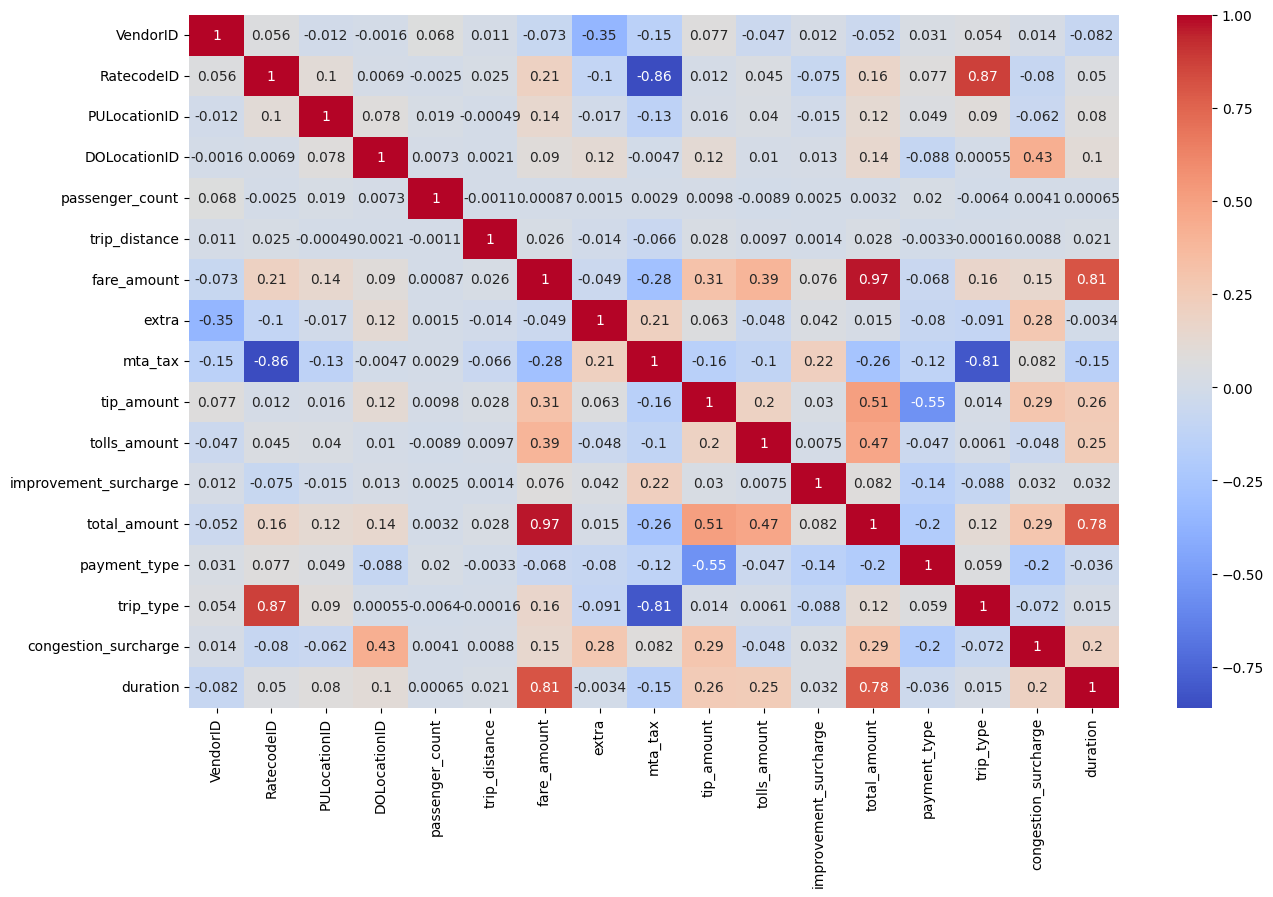

In [30]:
plt.figure(figsize=(15, 9))
sns.heatmap(df.corr(), annot=True, fmt=".2g",cmap="coolwarm")

We can clearly see that two variables are fare_amount and total_amount are highly correlate to duration, but that is obvious. 
The reason is if the duration is high, probably the total_amount is high due to trip_distance or congestation_surcharge. 

So for now, we will skip these two and also all negative and < 0.1 correlations variables

In [31]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [32]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

8.15915669661773

/home/ubuntu/anaconda3/envs/ml-ops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/ml-ops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


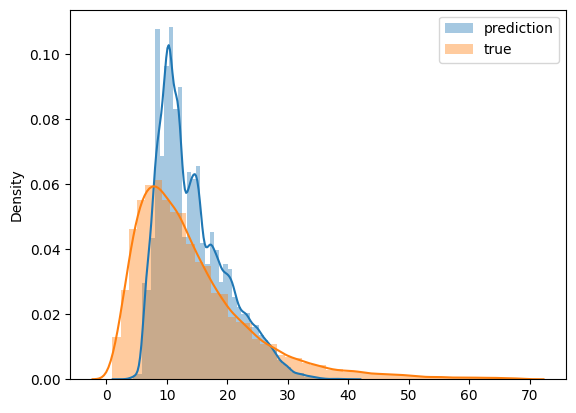

In [37]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="true")
plt.legend()

Well we see that our prediction distribution for y_train is little different.

In [38]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 70)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [39]:
train_df = read_dataframe('../../dataset/green_tripdata_2022-01.parquet')
val_df = read_dataframe('../../dataset/green_tripdata_2022-02.parquet')

In [40]:
train_df.shape

(59837, 21)

In [41]:
val_df.shape

(66488, 21)

In [43]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = train_df[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

In [54]:
X_train.shape

(59837, 471)

In [44]:
val_dicts = val_df[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [46]:
target = 'duration'
y_train = train_df[target].values
y_val = val_df[target].values

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

8.846638935176887

In [49]:
with open('../../models/lin_reg.bin', 'wb') as fp:
    pickle.dump((dv, lr), fp)

In [52]:
ls = Lasso(alpha=0.01)
ls.fit(X_train, y_train)

Lasso(alpha=0.01)

In [53]:
y_pred = ls.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

9.185555024152892